# How Anxcor uses XArray to simplify timeseries operations. 
## Part II.  Basic Signal Processing

Anxcor's basis in XArray.DataArrays allows it to perform signal processing routines in a very consize, expressive manner. Starting with the conversion process from last tutorial, we'll apply three basic processing routines to our seismic signals like most Seismic Ambient Noise processing workflows: Resample, demean & detrend, and bandpass filter.

In [1]:
from anxcor.xarray_routines import XArrayConverter, XArrayResample, XArrayRemoveMeanTrend, XArrayBandpass

### Test Data Acquisition

Ambient Noise Cross-Correlation is fun, and Christmas is fun, so lets get 6 hours of data from a station in Utah over Christmas day, 2018. To ensure we're working in units of displacement, a filter with corners 0.03, 0.05, 40, and 45 hz will be applied to the data, and the response will be removed with Obspys Stream.remove_response() function

In [2]:
from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime
client = Client("IRIS")
t  = UTCDateTime("2018-12-25 12:00:00").timestamp
st = client.get_waveforms("UU", "SPU", "*", "H*", t, t + 6*60*60,attach_response=True)
pre_filt = (0.003, 0.005, 40.0, 45.0)
st.remove_response(output='DISP', pre_filt=pre_filt)
st

3 Trace(s) in Stream:
UU.SPU.01.HHE | 2018-12-25T12:00:00.000000Z - 2018-12-25T18:00:00.000000Z | 100.0 Hz, 2160001 samples
UU.SPU.01.HHN | 2018-12-25T12:00:00.000000Z - 2018-12-25T18:00:00.000000Z | 100.0 Hz, 2160001 samples
UU.SPU.01.HHZ | 2018-12-25T12:00:00.000000Z - 2018-12-25T18:00:00.000000Z | 100.0 Hz, 2160001 samples

Lets take a look at the stream 

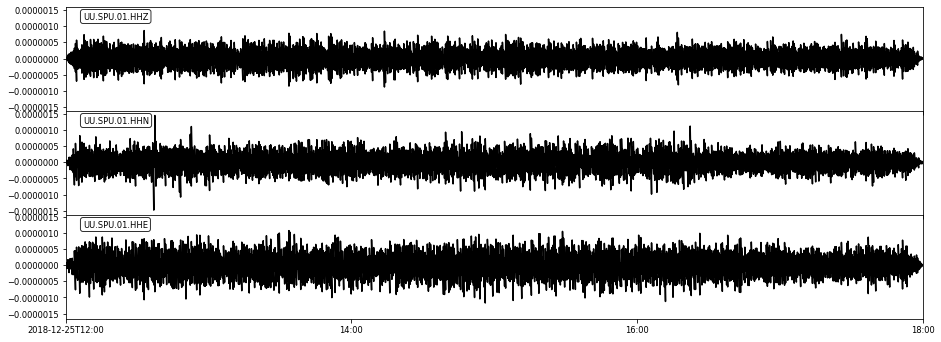

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
fig=plt.figure(figsize=(14,5))
st.plot(fig=fig)
plt.show()

### Convert to DataArray
The units of the y axis are in meters, so we seem to have noise on the order of a few $0.1\mu m$'s. It also looks like obspy automatically tapered the signals. 

Since it seems as though every trace in the signal:
* have the same sampling rate (100 Hz)
* have the same starttime (2018-12-25T12:00:00.000000)
* have the exact same duration and number of points (6hrs, 216001 samples)

It is safe to let anxcor attempt to convert these to an xarray.DataArray

In [4]:
converter = XArrayConverter()
xarray    = converter(st)
xarray

<xarray.DataArray 'default' (channel: 3, station_id: 1, time: 2160001)>
array([[[ -1.139592e-08,  -1.140542e-08, ...,   1.399025e-10,   1.398467e-10]],

       [[  3.096611e-09,   3.104802e-09, ...,   1.044315e-09,   1.043932e-09]],

       [[  3.808664e-10,   3.817600e-10, ...,  -3.495746e-10,  -3.498378e-10]]])
Coordinates:
  * channel     (channel) <U3 'HHE' 'HHN' 'HHZ'
  * station_id  (station_id) <U6 'UU.SPU'
  * time        (time) datetime64[ns] 2018-12-25T12:00:00 ... 2018-12-25T18:00:00
Attributes:
    delta:       0.01
    starttime:   1545739200.0
    operations:  xconvert

### Resampling
All the coordinate and metadata seems to match the traces above, so lets proceed to our first signal processing routine, Resampling. Anxcor provides the XArrayResample utility for this purpose.

Resampling is not a simple interpolation process, but performs the following steps in sequence:
* demeaning: array - array.mean()
* detrend: array - scipy.detrend
* lowpass filter: lowpass array with corner starting at nyquist of target sampling rate
* linear interpolation

The unit tests for this step include:
* ensure non null result
* ensure no introduced phase shift

In [5]:
resampler       = XArrayResample()
resampled_array = resampler(xarray)
resampled_array

<xarray.DataArray 'default' (channel: 3, station_id: 1, time: 216001)>
array([[[ -9.123181e-10,  -9.203630e-10, ...,   1.125197e-11,   1.143859e-11]],

       [[  2.453448e-10,   2.526055e-10, ...,   8.467065e-11,   8.443943e-11]],

       [[  3.072182e-11,   3.153332e-11, ...,  -2.827341e-11,  -2.840814e-11]]])
Coordinates:
  * channel     (channel) object 'HHE' 'HHN' 'HHZ'
  * station_id  (station_id) object 'UU.SPU'
  * time        (time) datetime64[ns] 2018-12-25T12:00:00 ... 2018-12-25T18:00:00
Attributes:
    delta:       0.1
    starttime:   1545739200.0
    operations:  xconvert\nresampled@10.0Hz

Anxcor XArray processing routines automatically update the metadata after processing. Here, the resampling routine we applied changed the sampling rate from 100 Hz to 10 Hz, and updated the delta attribute accordingly.

We can also see an additional string has been appended to the 'operations' attribute. Printing it out, we can get a nicely formatted message informing us of the steps that have been applied to this xarray:

In [6]:
print(resampled_array.attrs['operations'])

xconvert
resampled@10.0Hz


/home/kevin/anaconda3/envs/anxcor/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/home/kevin/anaconda3/envs/anxcor/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


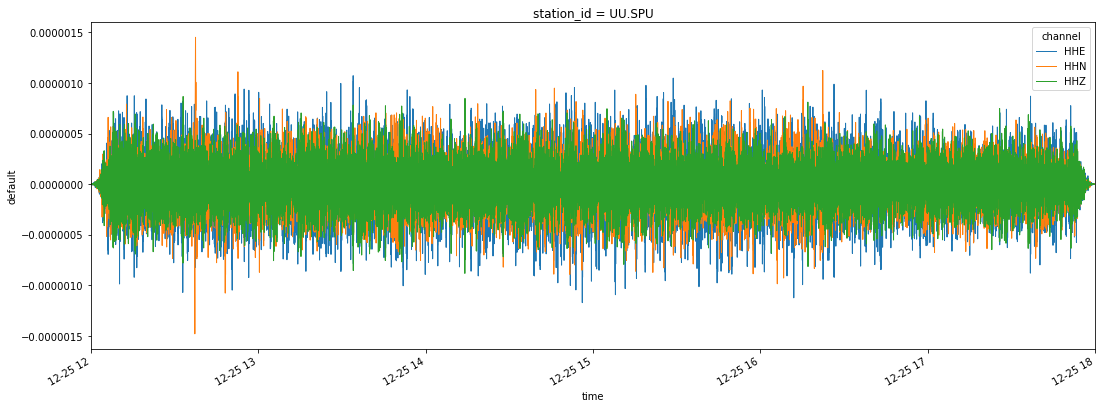

In [7]:
import numpy as np
xarray_squeezed = resampled_array.squeeze()
xarray_squeezed.plot.line(x='time',aspect=3, size=6,linewidth=1)
plt.gca().autoscale(enable=True, axis='x', tight=True)
plt.show()

Its hard to tell if the resampling was successful, so lets resample from the original data down to 0.1 Hz. Let's also tell the resampling method to apply a taper of ten percent to both sides of the window

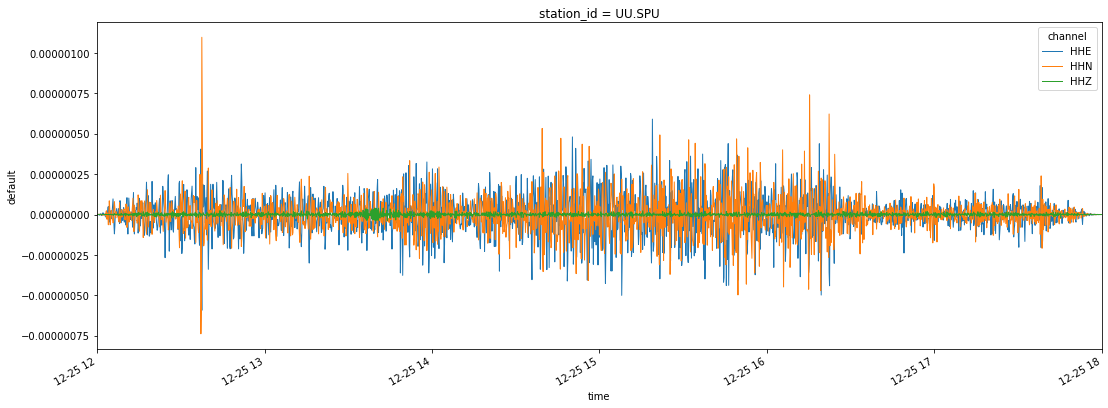

In [8]:
resampler       = XArrayResample(target_rate=0.1,taper=0.1)
resampled_array = resampler(xarray)
xarray_squeezed = resampled_array.squeeze()
xarray_squeezed.plot.line(x='time',aspect=3, size=6,linewidth=1)
plt.gca().autoscale(enable=True, axis='x', tight=True)
plt.show()

If the routines are to be believed, it appears as though the z component is the least noisy below 0.1 hz, while the E and N components have much more noise. All channels however, have had a lot of high frequency energy removed.

Let's print out the attributes again to ensure our processing routines have performed as expected

In [9]:
print(resampled_array.attrs['operations'])
print('\nnumber of points on time axis is: {}'.format(resampled_array.data.shape[-1]))

xconvert
resampled@0.1Hz

number of points on time axis is: 2161


### Remove Mean Trend

Because the linear interpolation and low pass filter of the Resample routine, it is common to perform a removal of the mean and trend directly after Resampling. Anxcor's XArrayRemoveMeanTrend is expressly for this purpose

In [10]:
remove_mean_trend = XArrayRemoveMeanTrend()
rm_mean_trend_array = remove_mean_trend(resampled_array)
print(rm_mean_trend_array.attrs['operations'])

xconvert
resampled@0.1Hz
remove_Mean&Trend


Comparing the sum's along the time axis of both the rm_mean_trend_array and the resampled_array can tell us how successful this operation is

In [11]:
print('channel names                  {}'.format(list(resampled_array.coords['channel'].values)))
print('cumsum of resampled_array:     {}'.format(np.cumsum(resampled_array.data,axis=-1)[:,0,-1]))
print('cumsum of rm_mean_trend_array: {}'.format(np.cumsum(rm_mean_trend_array.data,axis=-1)[:,0,-1]))

channel names                  ['HHE', 'HHN', 'HHZ']
cumsum of resampled_array:     [ -1.73116635e-07  -5.13377785e-08  -9.28539446e-09]
cumsum of rm_mean_trend_array: [ -9.91692619e-22   4.37733640e-22   9.29285719e-23]


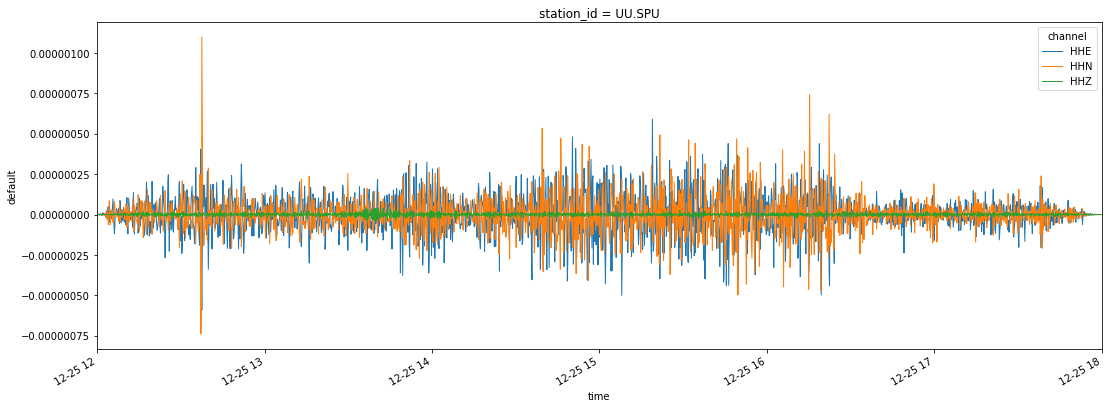

In [12]:
xarray_squeezed = rm_mean_trend_array.squeeze()
xarray_squeezed.plot.line(x='time',aspect=3, size=6,linewidth=1)
plt.gca().autoscale(enable=True, axis='x', tight=True)
plt.show()

### Bandpass

Bandpassing can help remove both low frequency and high frequency energy depending on our needs. Anxcor's XArrayBandpass is used for this purpose.

Lets redo the above steps with our initial 10Hz resampling rate, but bandpass the series between 3Hz and 0.01Hz. lets also use a 10% taper for the resampling and bandpassing steps

In [13]:
resampler       = XArrayResample(target_rate=10,taper=0.1)
remove_meaner   = XArrayRemoveMeanTrend()
bandpasser      = XArrayBandpass(upper_frequency=3.0,lower_frequency=0.01,taper=0.1)
resampled_array = resampler(xarray)
rm_trend_array  = remove_meaner(resampled_array)
bandpassed_array= bandpasser(rm_trend_array)
print(bandpassed_array.attrs['operations'])

xconvert
resampled@10Hz
remove_Mean&Trend
bandpass@0.01<3.0


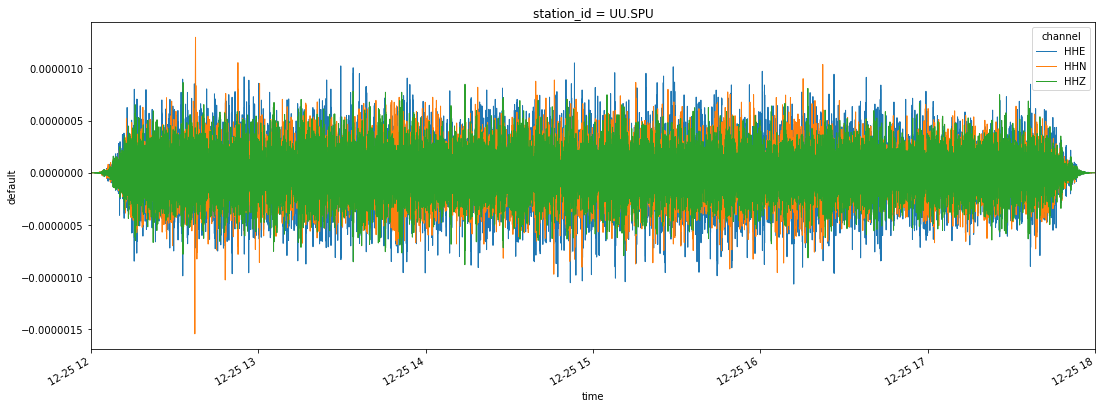

In [14]:
xarray_squeezed = bandpassed_array.squeeze()
xarray_squeezed.plot.line(x='time',aspect=3, size=6,linewidth=1)
plt.gca().autoscale(enable=True, axis='x', tight=True)
plt.show()

If our operations worked correctly, we should have three traces with low frequencies beyond 3 and below 0.01 Hz. Lets use scipy's fftpack to look at the power spectrum. We'll also plot the original amplitude spetrum prior to all the processing.

In [15]:
from scipy import fftpack
bandpassed_data = bandpassed_array.data.squeeze()

target_length   = fftpack.next_fast_len(bandpassed_data.shape[-1])
frequencies     = fftpack.fftshift(fftpack.fftfreq(target_length, d=bandpassed_array.attrs['delta']))

fft_spectrum    = fftpack.fftshift(fftpack.fft(bandpassed_data,target_length,axis=-1))
amplitude_spectrum  = np.abs(fft_spectrum)

original_data   = xarray.data.squeeze()

target_length   = fftpack.next_fast_len(original_data.shape[-1])
frequencies_orig= fftpack.fftshift(fftpack.fftfreq(target_length,d=xarray.attrs['delta']))

orig_amplitude_spec = np.abs(fftpack.fftshift(fftpack.fft(original_data,target_length)))


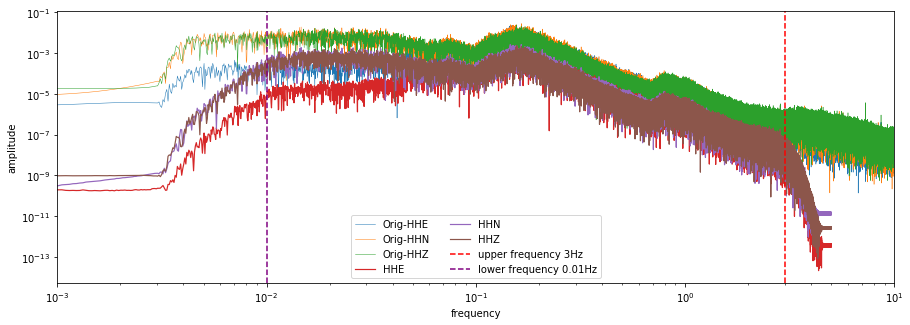

In [17]:
plt.figure(figsize=(15,5))
plt.loglog(frequencies_orig,orig_amplitude_spec[0,:],label='Orig-HHE',linewidth=0.5)
plt.loglog(frequencies_orig,orig_amplitude_spec[1,:],label='Orig-HHN',linewidth=0.5)
plt.loglog(frequencies_orig,orig_amplitude_spec[2,:],label='Orig-HHZ',linewidth=0.5)

plt.loglog(frequencies,amplitude_spectrum[0,:],label='HHE',linewidth=1.2)
plt.loglog(frequencies,amplitude_spectrum[1,:],label='HHN',linewidth=1.2)
plt.loglog(frequencies,amplitude_spectrum[2,:],label='HHZ',linewidth=1.2)

plt.axvline([3.0],label='upper frequency 3Hz',    color='red',linestyle='--')
plt.axvline([0.01],label='lower frequency 0.01Hz',color='purple',linestyle='--')
plt.xlim([1e-3,1e1])
plt.xlabel('frequency')
plt.ylabel('amplitude')
plt.legend(ncol=2)
plt.show()

Compared to the original, the final spectrum's power is a bit lower, but otherwise a pretty close mirror image of the data. In the next section we'll look at some more complicated signal processing techniques that Anxcor can use to boost the Ambient Noise Signal amplitudes